# KLSE Pipelines

## Common imports and functions

In [10]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import datetime as dt
import calendar as cal
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

### Pipeline imports

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
import numpy.core.defchararray as npf

### DataFrame selector class

In [12]:
# DataFrame selector
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

### Data Preprocessor

In [63]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        # Derive dividend year
        X['dividend_year'] = pd.to_datetime(X['ex_dividend_date'], format='%b %d, %Y').dt.year
        
        # Convert yield to float
        X['yield'] = X['yield'].replace('-','0')
        X['yield'] = X['yield'].str.rstrip('%').astype('float')
        
        # Get a unique code id
        X['code_id'] = df_dividends.groupby('code').ngroup()
        
        # Sum the yield by dividend year
        # X = X.groupby(['code_id','dividend_year']).agg({'dividend': np.sum, 'yield': np.sum})
        X = X.groupby(['code_id','dividend_year']).agg({'yield': np.sum})
        X = X.reset_index()
        # print(X)
        X = X.drop(['dividend_year'], axis=1)   # Drop the year now so only categorize based on the 
        return X
        # return X.drop(['ex_dividend_date','payment_date', 'code', 'name'], axis=1)   # Drop non numerical columns

### Processing pipelines

In [104]:
df_dividends = pd.read_csv('../dataset/KLSE_dividends_investing.csv')
df_dividends.info()
df_dividends.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2315 entries, 0 to 2314
Data columns (total 6 columns):
code                2315 non-null object
name                2315 non-null object
ex_dividend_date    2315 non-null object
dividend            2315 non-null float64
payment_date        2315 non-null object
yield               2315 non-null object
dtypes: float64(1), object(5)
memory usage: 108.6+ KB


,code,name,ex_dividend_date,dividend,payment_date,yield
0,5218,Sapura Energy Bhd (SAEN),"Apr 12, 2017",0.0100,"Apr 28, 2017",2.94%
1,5218,Sapura Energy Bhd (SAEN),"Jul 29, 2015",0.0135,"Aug 28, 2015",0.72%
2,138,MY EG Services Bhd (MYEG),"Apr 24, 2018",0.0170,"May 25, 2018",1.30%
3,138,MY EG Services Bhd (MYEG),"Jan 04, 2018",0.0170,"Feb 06, 2018",0.63%
4,138,MY EG Services Bhd (MYEG),"Apr 21, 2017",0.0137,"May 24, 2017",0.64%
5,138,MY EG Services Bhd (MYEG),"Dec 23, 2016",0.0120,"Jan 25, 2017",0.74%
6,138,MY EG Services Bhd (MYEG),"Apr 22, 2016",0.0120,"May 24, 2016",0.56%
7,138,MY EG Services Bhd (MYEG),"Jan 04, 2016",0.0095,"Feb 04, 2016",0.44%
8,128,Frontken Corporation Bhd (FRKN),"Sep 15, 2017",0.0050,"Oct 04, 2017",0.60%
9,9385,Lay Hong Bhd (LAYH),"Oct 18, 2018",0.0050,"Nov 15, 2018",0.79%


In [105]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from future_encoders import OneHotEncoder
from sklearn.pipeline import FeatureUnion

standard_attribs = list(df_dividends)
code_attrib = ["code"]

standard_pipeline = Pipeline([
        ('selector', DataFrameSelector(standard_attribs)),
        ('preprocessor', DataPreprocessor()),
        ('scaler', StandardScaler()),
    ])

#code_pipeline = Pipeline([
#       ('selector', DataFrameSelector(code_attrib)),
#       ('code_encoder', OneHotEncoder(sparse=False))
#    ])



full_pipeline = FeatureUnion(transformer_list=[
        ("standard_attribs", standard_pipeline),
        #("code_attrib", code_pipeline)
    ])

df_prepared = full_pipeline.fit_transform(df_dividends)
df_prepared

array([[-1.75239362, -0.51068345],
       [-1.74645861, -0.22858215],
       [-1.74645861,  1.43537471],
       ...,
       [ 1.71365199,  0.15710321],
       [ 1.71365199,  1.01001885],
       [ 1.71365199, -0.2351939 ]])

### Categorize the stocks

2051.9813125950645


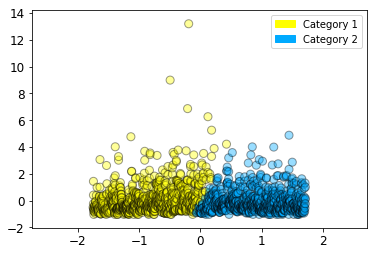

1174.7945358716493


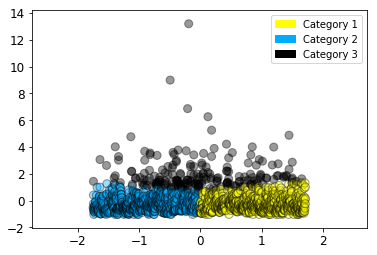

944.2288664962965


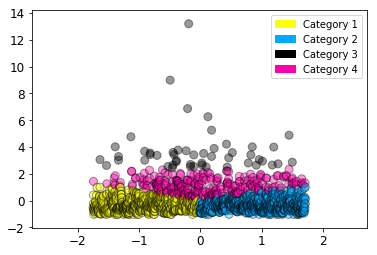

781.5924514573288


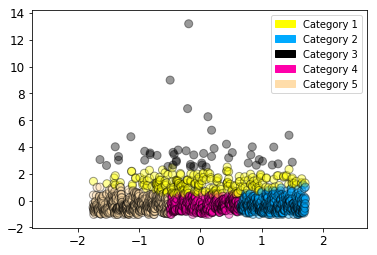

647.9748620247315


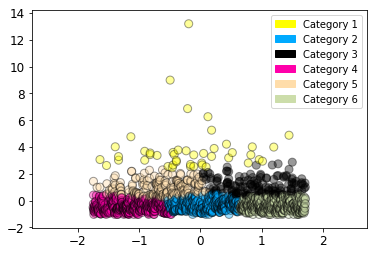

527.6675634179454


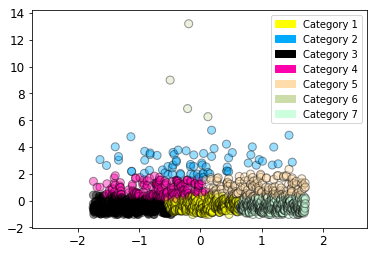

466.3063970097444


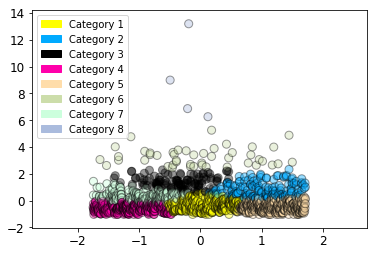

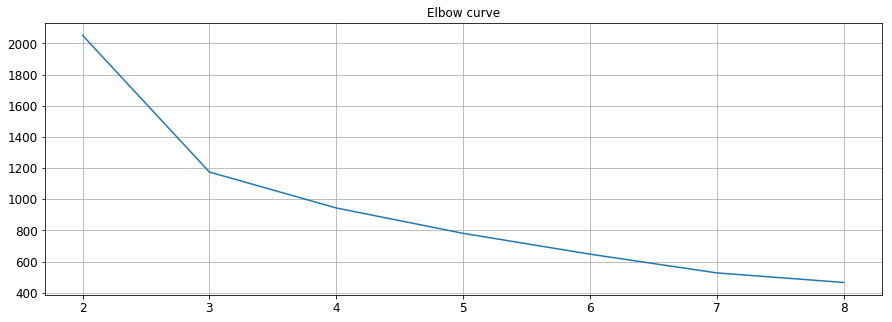

In [106]:
from sklearn.cluster import KMeans
from adspy_shared_utilities import plot_labelled_scatter
from sklearn import metrics
from scipy.spatial.distance import cdist

# print([ "Category " + str(i) for i in list(range(1,3)) ] )
      
distortions = []
for k in range(2,9):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_prepared)
    print(kmeans.inertia_)
    distortions.append(kmeans.inertia_)
    plot_labelled_scatter(df_prepared, kmeans.labels_, 
                          [ "Category " + str(i) for i in list(range(1,k+1)) ] )

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 9), distortions)
plt.grid(True)
plt.title('Elbow curve')

### From the elbow curve, the number of clusters = 3. Build the full pipeline

1174.794851283647


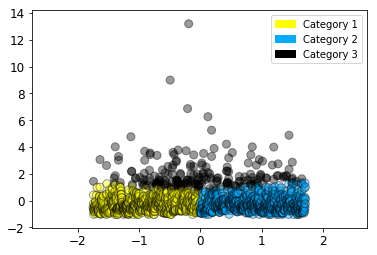

[[-1.75239362 -0.51068345]
 [-1.74645861 -0.22858215]
 [-1.74645861  1.43537471]
 ...
 [ 1.71365199  0.15710321]
 [ 1.71365199  1.01001885]
 [ 1.71365199 -0.2351939 ]]


In [107]:
df_prepared = full_pipeline.fit_transform(df_dividends)
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_prepared)
print(kmeans.inertia_)
plot_labelled_scatter(df_prepared, kmeans.labels_, 
                      [ "Category " + str(i) for i in list(range(1,4)) ] )

print(df_prepared)

### Show the stocks clusters

In [108]:
# print(df_dividends)
data_preprocessor = DataPreprocessor()
df_preprocessed = data_preprocessor.fit_transform(df_dividends.copy())   ## Create a new copy
# standard_scaler = StandardScaler()
# df_normalized = standard_scaler.fit_transform(df_preprocessed)
# df_normalized.shape

df_preprocessed['category'] = kmeans.labels_
# df_preprocessed['code_id'].unique()
# print(df_preprocessed.shape)
# print(kmeans.labels_.shape)
df_preprocessed.head(10)

,code_id,yield,category
0,0,2.35,0
1,1,3.63,0
2,1,11.18,2
3,1,6.53,0
4,2,0.00,0
5,2,1.04,0
6,2,1.27,0
7,2,2.02,0
8,3,2.27,0
9,3,1.82,0


In [115]:
df_lookup = df_dividends.copy()
df_lookup['dividend_year'] = pd.to_datetime(df_lookup['ex_dividend_date'], format='%b %d, %Y').dt.year
df_lookup['yield'] = df_lookup['yield'].replace('-','0')
df_lookup['yield'] = df_lookup['yield'].str.rstrip('%').astype('float')
df_lookup['code_id'] = df_lookup.groupby('code').ngroup()       
df_lookup = df_lookup.groupby(['code_id','dividend_year','code','name']).agg({'yield': np.sum})
df_lookup = df_lookup.reset_index()
df_lookup.head(10)

,code_id,dividend_year,code,name,yield
0,0,2016,0001,Supercomnet Technologies Bhd (SCTH),2.35
1,1,2016,0011,Brite Tech Bhd (BECH),3.63
2,1,2017,0011,Brite Tech Bhd (BECH),11.18
3,1,2018,0011,Brite Tech Bhd (BECH),6.53
4,2,2014,0012,Three A Resources Bhd (THEA),0.00
5,2,2015,0012,Three A Resources Bhd (THEA),1.04
6,2,2016,0012,Three A Resources Bhd (THEA),1.27
7,2,2017,0012,Three A Resources Bhd (THEA),2.02
8,3,2016,0023,IFCA MSC Bhd (IFCA),2.27
9,3,2017,0023,IFCA MSC Bhd (IFCA),1.82


### Join df_dividends with df_preprocessed

In [144]:
df_categorized = pd.merge(df_preprocessed, df_lookup, how='left', left_on=['code_id','yield'], right_on=['code_id', 'yield'])

In [160]:
# df_categorized.head(1000)

# df_dividends[df_dividends['code'] == '0011'].head(20)
df_categorized[df_categorized['category'] == 2].head(200)

,code_id,yield,category,dividend_year,code,name
2,1,11.18,2,2017,0011,Brite Tech Bhd (BECH)
44,19,18.56,2,2017,0099,Scicom MSC Bhd (SCCM)
85,37,16.56,2,2017,0158,SCC Holdings Bhd (SCCH)
131,58,12.31,2,2016,1155,Malayan Banking Bhd (MBBM)
132,58,10.42,2,2017,1155,Malayan Banking Bhd (MBBM)
144,61,13.09,2,2016,1198,MAA Group Bhd (MAAS)
145,61,22.88,2,2017,1198,MAA Group Bhd (MAAS)
173,70,18.35,2,2017,1562,Berjaya Sports Toto Bhd (BSTB)
174,70,19.57,2,2018,1562,Berjaya Sports Toto Bhd (BSTB)
189,75,10.76,2,2016,1724,Paramount Corporation Bhd (PRMS)
